In [1]:
import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from statsmodels.graphics.api import abline_plot
import seaborn as sns
import umap

np.random.seed(10)

def get_binary_covariate(covariate, covariate_level, data):
    covariate_list = np.zeros((data.obs.shape[0]))
    for i in range(data.obs.shape[0]):
        ### select the ith element of 
        if data.obs[[covariate]].squeeze()[i] == covariate_level:
            covariate_list[i] = 1
    return covariate_list


In [2]:
#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/input_data_designMat/inputdata_rat_set1_countData_2.h5ad') ## attributes removed
data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]

### print head pf the data.obs
print(data.obs.head())
data_sub = data_numpy
strain = data.obs.strain
#### sample metadata
y_cluster =data.obs.cluster 
y_sample = data.obs.sample
y_sample = data.obs[['sample']].squeeze()
y_strain_str = data.obs[['strain']].squeeze()

y_strain = get_binary_covariate('strain', 'DA', data=data)


## working with the rat data
num_cells = data_sub.shape[0]
num_genes = data_sub.shape[1]
num_genes = 2000

#### select num_genes genes based on variance
### calculate the variance for each gene
gene_vars = np.var(data_numpy, axis=0)
### select the top num_genes genes with the highest variance
gene_idx = np.argsort(gene_vars)[::-1][0:num_genes]
### subset the data matrix to the top num_genes genes
data_numpy = data_numpy[:, gene_idx]

#### randomly select num_genes genes
#gene_idx = random.sample(range(0, data_numpy.shape[1]), num_genes)
#data_numpy = data_numpy[:, gene_idx]

y = data_numpy


                          orig.ident  nCount_RNA  nFeature_RNA sample strain  \
DA_01_AAACCTGAGACTTGAA-1           0      3007.0          1244  DA_01     DA   
DA_01_AAACCTGAGCCATCGC-1           0      2176.0           919  DA_01     DA   
DA_01_AAACCTGAGGGAAACA-1           0      1978.0           829  DA_01     DA   
DA_01_AAACCTGCACCCATTC-1           0      2702.0          1104  DA_01     DA   
DA_01_AAACCTGCATGCATGT-1           0      2664.0          1061  DA_01     DA   

                         cluster           refined_cell_ID  
DA_01_AAACCTGAGACTTGAA-1       5  DA_01_AAACCTGAGACTTGAA-1  
DA_01_AAACCTGAGCCATCGC-1       9  DA_01_AAACCTGAGCCATCGC-1  
DA_01_AAACCTGAGGGAAACA-1       2  DA_01_AAACCTGAGGGAAACA-1  
DA_01_AAACCTGCACCCATTC-1      11  DA_01_AAACCTGCACCCATTC-1  
DA_01_AAACCTGCATGCATGT-1       5  DA_01_AAACCTGCATGCATGT-1  


In [44]:
### generating the design matrix for the rat data

# x = y_strain ## only strain as a covariate
#y_DA_01 = get_binary_covariate('sample', 'DA_01', data=data)
#y_LEW_01 = get_binary_covariate('sample', 'LEW_01', data=data)

### make a design matrix with the y_strain, y_DA_01, y_LEW_01
#x = np.column_stack((y_strain, y_DA_01, y_LEW_01))


### define x as the design matrix with data.obs.nCount_RNA as covariate and a column of intercept
x = np.column_stack((np.ones((data.obs.shape[0],1)), data.obs.nCount_RNA))

num_vars = x.shape[1]
print(x[0:3,:])
print(x.shape)

[[1.000e+00 3.007e+03]
 [1.000e+00 2.176e+03]
 [1.000e+00 1.978e+03]]


In [51]:
print(x[0:3,:])


[[1.000e+00 3.007e+03]
 [1.000e+00 2.176e+03]
 [1.000e+00 1.978e+03]]


In [50]:
## dimension of x
print(x.shape)
## dimension of y
print(y.shape)
i=1
y[:, i].shape

(23036, 2)
(23036, 2000)


(23036,)

In [55]:

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []


### fitting a GLM model for each gene
# model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())


fam = sm.families.Poisson()
ind = sm.cov_struct.Independence() # 
#ind = sm.cov_struct.Exchangeable() ### leads to convergence error


### time the fitting process
start_time = time.time()

for i in range(len(y[0])):


    ###fitting a GEE model for each gene
    y_a_gene = y[:, i]
    #model = sm.GEE(y_a_gene, x, family=sm.families.Poisson())
    model = sm.GEE(endog=y_a_gene, exog=x, groups=y_sample, cov_struct=ind, family=fam)
    result = model.fit()


    models.append([result])
    coefficient.append([result.params])
    pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    yhat.append([result.predict()])
    fittedvalues.append([result.fittedvalues])

    tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    resid_working.append([result.resid_working])
    

end_time = time.time()
print('time to fit the model: ', end_time - start_time)

pvalue = np.asarray(pvalue).reshape(num_genes, num_vars)
coefficient = np.asarray(coefficient).reshape(num_genes, num_vars)
tvalues = np.asarray(tvalues).reshape(num_genes, num_vars)
#### print the head of the pvalues
print(pvalue[0:5, :])

yhat = np.asarray(yhat).reshape(num_genes, num_cells)
fittedvalues = np.asarray(fittedvalues).reshape(num_genes, num_cells)
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
resid_deviance = np.asarray(resid_deviance).reshape(num_genes, num_cells)
resid_response = np.asarray(resid_response).reshape(num_genes, num_cells)
resid_working = np.asarray(resid_working).reshape(num_genes, num_cells)


/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1330: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)
/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1330: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)
/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/cov_struct.py:252: RuntimeWarning: invalid value encountered in true_divide
  resid = (endog[i] - expval) / stdev
/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:576: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/delaram/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/cov_struct.py:293:

KeyboardInterrupt: 

In [53]:
def plot_pca(pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=strain_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                            mpatches.Patch(color='hotpink', label='DA')])
        plt.show()

        ## color PCA based on cluster
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=c, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.show()

        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
                            mpatches.Patch(color='forestgreen', label='LEW_02'),
                            mpatches.Patch(color='pink', label='DA_01'),
                            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
        plt.show()


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()


def plot_umap(pca , title='UMAP of the PC components of the gene expression matrix'):

    ### apply UMAP to teh PCA components
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(pca.components_.T)
    print('embedding shape: ', embedding.shape)
    
    ### plot the UMAP embedding
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=strain_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                        mpatches.Patch(color='hotpink', label='DA')])
    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=sample_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
            mpatches.Patch(color='forestgreen', label='LEW_02'),
            mpatches.Patch(color='pink', label='DA_01'),
            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=c, s=1)
    plt.title(title)
    plt.show()



#### generating the list of colors for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(y_cluster)))) ### set the color for each cluster
my_color = {}
### define a dictionary to map the cluster number to the color
list_levels = list(set(y_cluster))
for i in range(len(set(list_levels))):
    my_color[list_levels[i]] = colors[i]
### generate a list containing the corresponding color for each cluster
c = [my_color[y_cluster[i]] for i in range(len(y_cluster))]


### generating the list of colors for samples
my_color = {'LEW_01': 'palegreen', 'LEW_02':'forestgreen', 'DA_01':'pink', 'DA_02':'orchid'}
### generate a list containing the corresponding color for each sample
sample_color = [my_color[y_sample[i]] for i in range(len(y_sample))]

my_color = {'LEW': 'springgreen', 'DA':'hotpink'}
strain_color = [my_color[y_strain_str[i]] for i in range(len(y_strain_str))]

### applying PCA to the data matrix
num_components = 10


noise_variance:  9.01774461376168


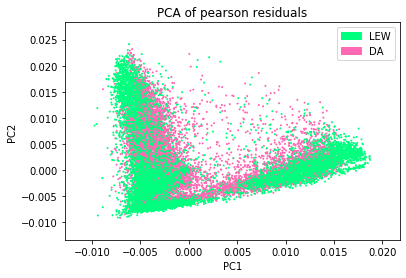

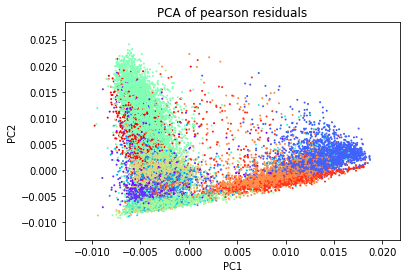

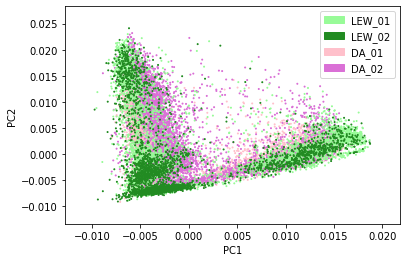

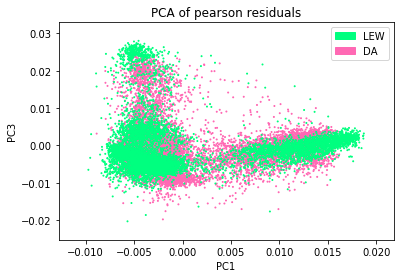

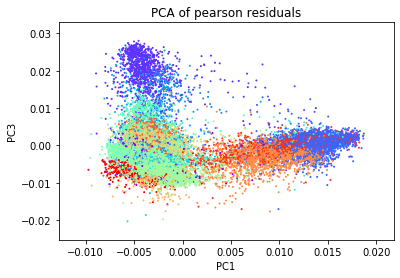

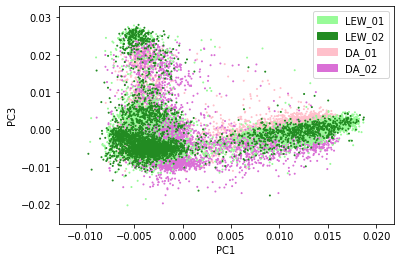

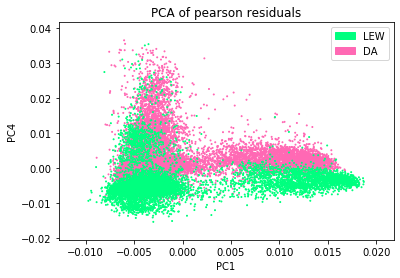

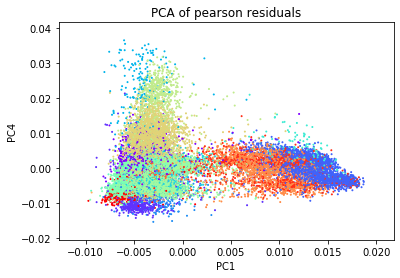

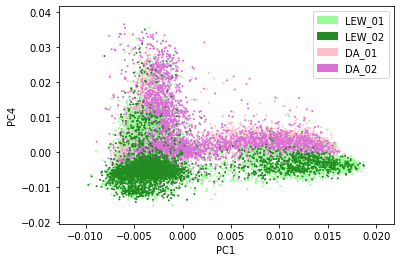

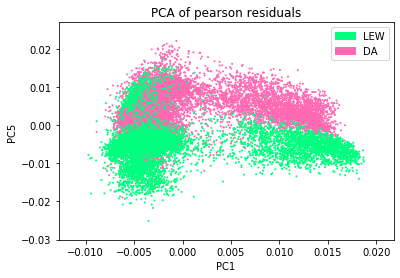

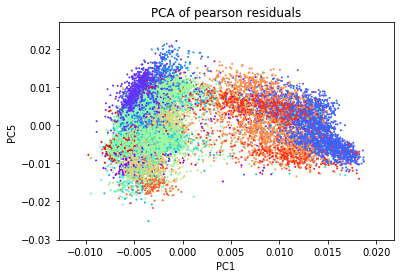

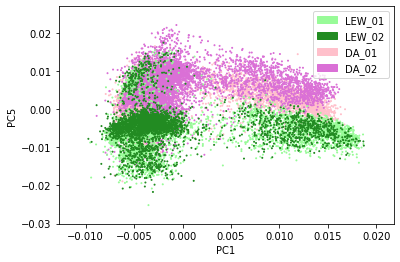

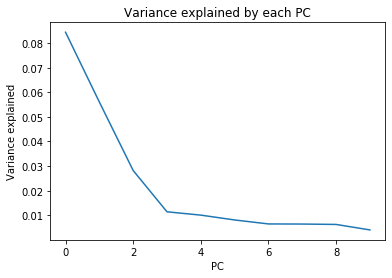

embedding shape:  (23036, 2)


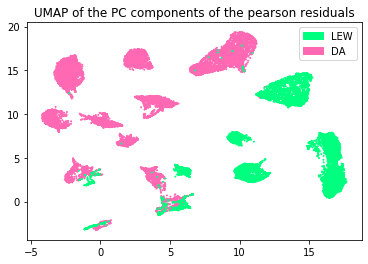

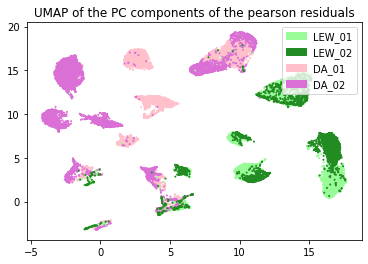

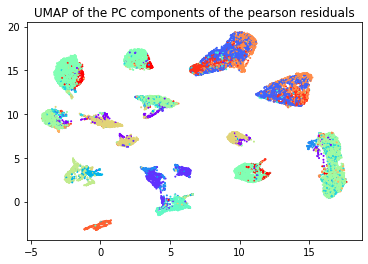

In [54]:
### applying PCA to the pearson residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_pearson)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 5, title='PCA of pearson residuals')
plot_umap(pca, title='UMAP of the PC components of the pearson residuals')
